In [70]:
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo


# set float display default
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Read the data

In [2]:
df = pd.read_csv("covid-19_2020-12-31_survey_covid-19_impact_4850691271294976_4850691271294976_all.csv")

In [3]:
df.head()

,submission_id,observation_id,observed_time,user_id,form_id,form_version,form_name,form_tier,campaign_id,campaign_name,project_id,project_name,organization_id,gender,age,geography,financial_situation,education,employment_status,ethnicity,religion,batch_date,location_feature_id,location_feature_name,observation_lat,observation_lon,HASC_code,L0_name,L1_name,L2_name,intro_input,the_following_questions_will_ask_you_about_the_spread_of_covid_19_in_your_area,how_concerned_are_you_about_the_spread_of_covid_19_in_your_community,have_you_personally_contracted_covid_19,did_you_seek_medical_care_to_treat_covid_19,how_satisfied_were_you_with_the_level_of_care_you_received,"how_confident_are_you_that_you_are_immune_should_a_""second_wave""_emerge_in_the_future",why_were_you_not_tested,how_concerned_are_you_that_you_personally_will_contract_covid_19,how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19,do_you_know_if_testing_for_coronavirus_is_available_in_your_city,what_kind_of_locations_or_facilities_are_offering_testing_in_your_city,the_following_questions_will_ask_you_about_the_government_response_to_and_economic_impact_of_the_covid_19_pandemic_in_your_area,which_of_the_following_statements_best_describes_your_attitude_towards_your_local_town_or_municipality_governmentu2019s_response_to_covid_19_my_local_government_hasu2026,do_you_trust_your_local_or_national_government_to_make_more_effective_decisions_regarding_covid_19,are_non_essential_businesses_in_your_area_closed,are_non_essential_businesses_closed_by_declaration_of_authorities_or_voluntarily,when_do_you_believe_non_essential_businesses_should_open_in_your_area,what_do_you_think_of_the_timing_of_the_decision_to_re_open_non_essential_businesses_in_your_area,which_of_the_following_activities_will_you_feel_comfortable_with_now_or_immediately_after_non_essential_businesses_re_open,when_do_you_anticipate_feeling_comfortable_shopping_at_non_essential_stores,when_do_you_anticipate_feeling_comfortable_shopping_at_nonessential_stores_copy,when_do_you_anticipate_feeling_comfortable_riding_public_transportation,when_do_you_anticipate_feeling_comfortable_traveling_by_airplane,how_difficult_has_it_been_for_you_to_find_groceries_and_other_items,which_of_the_following_categories_of_items_were_difficult_or_impossible_to_find,from_which_of_the_following_places_have_you_purchased_or_looked_for_food_and_other_supplies,have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19,how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy,how_long_do_you_believe_it_will_take_for_your_local_economy_to_rebound_to_its_pre_covid_19_status,the_following_questions_will_ask_you_about_the_impact_of_the_covid_19_pandemic_on_your_day_to_day_life_and_personal_finances,has_your_income_been_at_all_affected_by_the_covid_19_pandemic,in_the_past_week_how_much_did_you_reduce_the_number_of_hours_worked_compared_to_a_typical_week,how_long_do_you_believe_it_will_take_for_your_income_to_reach_its_pre_covid_19_levels,how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity,have_you_left_or_are_you_planning_to_leave_your_home_today,why_did_you_or_are_you_planning_to_leave_your_home_today,when_you_leave_your_home_do_you_typically_wear_a_face_mask,why_do_you_not_wear_a_mask_when_you_leave_your_home,one_last_question_what_do_you_think_has_negatively_impacted_your_daily_life_most_because_of_covid_19,do_you_have_school_aged_children_living_in_your_household,has_their_school_closed_due_to_covid_19,what_do_you_think_of_the_decision_to_re_open_schools_in_your_area,have_you_canceled_or_altered_travel_plans_because_of_the_coronavirus_covid_19,have_you_been_practicing_social_distancing_when_you_leave_the_house,which_of_the_following_factors_have_inclined_you_to_not_closely_follow_the_guidance_of_

In [4]:
df['batch_date'] = pd.to_datetime(df['batch_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866985 entries, 0 to 2866984
Data columns (total 89 columns):
 #   Column                                                                                                                                                                                                               Dtype         
---  ------                                                                                                                                                                                                               -----         
 0   submission_id                                                                                                                                                                                                        int64         
 1   observation_id                                                                                                                                                                         

# Recode sentiment variables

In [6]:
recode_cols = [col for col in df.columns if 'concerned' in col]
print(recode_cols)

['how_concerned_are_you_about_the_spread_of_covid_19_in_your_community', 'how_concerned_are_you_that_you_personally_will_contract_covid_19', 'how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19', 'how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy', 'how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity']


In [7]:
for col in recode_cols: 
    print(df[col].value_counts())


Very concerned                       1172048
Concerned                            1085155
Neither concerned nor unconcerned     460392
Unconcerned                           102467
Very unconcerned                       46921
Name: how_concerned_are_you_about_the_spread_of_covid_19_in_your_community, dtype: int64
Concerned                            590821
Very concerned                       567626
Neither concerned nor unconcerned    284088
Unconcerned                          100953
Very unconcerned                      53332
Name: how_concerned_are_you_that_you_personally_will_contract_covid_19, dtype: int64
Concerned                            608838
Very concerned                       569473
Neither concerned nor unconcerned    281042
Unconcerned                           96495
Very unconcerned                      40972
Name: how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19, dtype: int64
Neither concerned nor unconcerned    82

In [8]:
scale_mapper = {'Very concerned':5, 
                'Concerned':4, 
                'Neither concerned nor unconcerned':3,
                'Unconcerned':2,
                'Very unconcerned':1}

# Map feature values to scale
for col in recode_cols:
    df[col]=df[col].replace(scale_mapper)

In [9]:
for col in recode_cols: 
    print(df[col].value_counts())

5.00    1172048
4.00    1085155
3.00     460392
2.00     102467
1.00      46921
Name: how_concerned_are_you_about_the_spread_of_covid_19_in_your_community, dtype: int64
4.00    590821
5.00    567626
3.00    284088
2.00    100953
1.00     53332
Name: how_concerned_are_you_that_you_personally_will_contract_covid_19, dtype: int64
4.00    608838
5.00    569473
3.00    281042
2.00     96495
1.00     40972
Name: how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19, dtype: int64
3.00    824299
2.00    682182
5.00    599290
4.00    506716
1.00    254494
Name: how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy, dtype: int64
5.00    1274374
4.00    1030223
3.00     421689
2.00      83314
1.00      57382
Name: how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity, dtype: int64


In [10]:
df['has_your_income_been_at_all_affected_by_the_covid_19_pandemic'].value_counts()

Yes, I have seen a reduction in my paycheck/hours/sales    1391552
No, not at all                                              771144
Yes, I have been laid off or have otherwise lost my job     704287
Name: has_your_income_been_at_all_affected_by_the_covid_19_pandemic, dtype: int64

In [11]:
scale_mapper2 = {'Yes, I have been laid off or have otherwise lost my job':3, 
                 'Yes, I have seen a reduction in my paycheck/hours/sales':2, 
                 'No, not at all':1}

df['has_your_income_been_at_all_affected_by_the_covid_19_pandemic']=df['has_your_income_been_at_all_affected_by_the_covid_19_pandemic'].replace(scale_mapper2)

In [12]:
df['has_your_income_been_at_all_affected_by_the_covid_19_pandemic'].value_counts()

2.00    1391552
1.00     771144
3.00     704287
Name: has_your_income_been_at_all_affected_by_the_covid_19_pandemic, dtype: int64

In [13]:
print(df['how_difficult_has_it_been_for_you_to_find_groceries_and_other_items'].value_counts())
print(df['have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19'].value_counts())
print(df['how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future'].value_counts())

Neither difficult nor easy    1094239
Easy                           672506
Difficult                      572734
Very easy                      292578
Very difficult                 234926
Name: how_difficult_has_it_been_for_you_to_find_groceries_and_other_items, dtype: int64
Minor effect       857331
Unsure             584004
Moderate effect    554431
Major effect       468880
No effect          402338
Name: have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19, dtype: int64
did not exist           321897
Very confident          166920
Somewhat confident       32875
Not very confident        9814
Not at all confident      4007
Name: how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future, dtype: int64


In [14]:
scale_1 = {'Very difficult':5,
          'Difficult':4,
          'Neither difficult nor easy':3,
          'Easy':2,
          'Very easy':1}

scale_2 = {'Major effect':5,
          'Moderate effect':4,
          'Unsure':3,
          'Minor effect':2,
          'No effect':1}

scale_3 = {'Not at all confident':4,
           'Not very confident':3,
           'Somewhat confident':2,
           'Very confident':1,
           'did not exist':np.nan}  #this should be NA, not 0


In [15]:
# scale_1
df['how_difficult_has_it_been_for_you_to_find_groceries_and_other_items']=df['how_difficult_has_it_been_for_you_to_find_groceries_and_other_items'].replace(scale_1)

# scale_2
df['have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19']=df['have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19'].replace(scale_2)

# scale_3
df['how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future']=df['how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future'].replace(scale_3)

In [16]:
print(df['how_difficult_has_it_been_for_you_to_find_groceries_and_other_items'].value_counts())
print(df['have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19'].value_counts())
print(df['how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future'].value_counts())

3.00    1094239
2.00     672506
4.00     572734
1.00     292578
5.00     234926
Name: how_difficult_has_it_been_for_you_to_find_groceries_and_other_items, dtype: int64
2.00    857331
3.00    584004
4.00    554431
5.00    468880
1.00    402338
Name: have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19, dtype: int64
1.00    166920
2.00     32875
3.00      9814
4.00      4007
Name: how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future, dtype: int64


In [17]:
recode_cols2 = [col for col in df.columns if 'how_much' in col]
print(recode_cols2)

['in_the_past_week_how_much_did_you_reduce_the_number_of_hours_worked_compared_to_a_typical_week', 'how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health', 'how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d', 'how_much_do_you_agree_with_the_following_statement_u201cvaccines_are_necessary_to_promote_herd_immunity_and_ensure_the_health_and_safety_of_everyone_in_the_community_including_immunocompromised_individuals_u201d']


In [18]:
recode_cols2=recode_cols2[1:]

In [19]:
for col in recode_cols2: 
    print(df[col].value_counts())

Some negative impact                    946250
Neither positive nor negative impact    702613
Extreme negative impact                 695120
did not exist                           321897
Some positive impact                    149027
Extreme positive impact                  52048
Name: how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health, dtype: int64
Agree                         1293294
Neither agree nor disagree     710493
Strongly agree                 689905
Disagree                       129363
Strongly disagree               43929
Name: how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d, dtype: int64
did not exist                 2732598
Strongly agree                  56901
Agree                           49367
Neither agree nor disagree      23528
Disagree                         2882
Strongly disa

In [20]:
scale_4 = {'Extreme negative impact':5,
          'Some negative impact':4,
          'Neither positive nor negative impact':3,
          'Some positive impact':2,
          'Extreme positive impact':1,
          'did not exist': np.nan}


        

scale_5 = {'Strongly disagree':5,
          'Disagree':4,
          'Neither agree nor disagree':3,
          'Agree':2,
          'Strongly agree':1, 
          'did not exist': np.nan}


In [21]:
df[recode_cols2[0]]=df[recode_cols2[0]].replace(scale_4)
df[recode_cols2[1]]=df[recode_cols2[1]].replace(scale_5)
df[recode_cols2[2]]=df[recode_cols2[2]].replace(scale_5)


In [22]:
for col in recode_cols2: 
    print(df[col].value_counts())

4.00    946250
3.00    702613
5.00    695120
2.00    149027
1.00     52048
Name: how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health, dtype: int64
2.00    1293294
3.00     710493
1.00     689905
4.00     129363
5.00      43929
Name: how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d, dtype: int64
1.00    56901
2.00    49367
3.00    23528
4.00     2882
5.00     1706
Name: how_much_do_you_agree_with_the_following_statement_u201cvaccines_are_necessary_to_promote_herd_immunity_and_ensure_the_health_and_safety_of_everyone_in_the_community_including_immunocompromised_individuals_u201d, dtype: int64


In [23]:
recode_cols3 = [col for col in df.columns if 'satisfied' in col]
print(recode_cols3)

['how_satisfied_were_you_with_the_level_of_care_you_received', 'how_satisfied_are_you_with_the_media_coverage_of_covid_19']


In [24]:
for col in recode_cols3: 
    print(df[col].value_counts())

Very satisfied                        134537
Satisfied                              37458
Neither satisfied nor dissatisfied      6515
Dissatisfied                            2296
Very dissatisfied                       1042
Name: how_satisfied_were_you_with_the_level_of_care_you_received, dtype: int64
Satisfied                             1236658
Neither satisfied nor dissatisfied     874715
Very satisfied                         443261
Dissatisfied                           221753
Very dissatisfied                       89535
Name: how_satisfied_are_you_with_the_media_coverage_of_covid_19, dtype: int64


In [25]:
scale_6 = {'Very dissatisfied':5,
           'Dissatisfied':4,
           'Neither satisfied nor dissatisfied':3,
           'Satisfied':2, 
           'Very satisfied':1}

for col in recode_cols3:
    df[col]=df[col].replace(scale_6)

In [26]:
for col in recode_cols3: 
    print(df[col].value_counts())

1.00    134537
2.00     37458
3.00      6515
4.00      2296
5.00      1042
Name: how_satisfied_were_you_with_the_level_of_care_you_received, dtype: int64
2.00    1236658
3.00     874715
1.00     443261
4.00     221753
5.00      89535
Name: how_satisfied_are_you_with_the_media_coverage_of_covid_19, dtype: int64


In [27]:
df['when_you_leave_your_home_do_you_typically_wear_a_face_mask'].value_counts()

Yes, always       1562359
Yes, sometimes     917750
No, never          298416
did not exist       88396
Name: when_you_leave_your_home_do_you_typically_wear_a_face_mask, dtype: int64

In [28]:
scale_7 = {'Yes, always':1, 
           'Yes, sometimes':2, 
           'No, never':3, 
           'did not exist': np.nan}

df['when_you_leave_your_home_do_you_typically_wear_a_face_mask']=df['when_you_leave_your_home_do_you_typically_wear_a_face_mask'].replace(scale_7)

In [29]:
df['when_you_leave_your_home_do_you_typically_wear_a_face_mask'].value_counts()

1.00    1562359
2.00     917750
3.00     298416
Name: when_you_leave_your_home_do_you_typically_wear_a_face_mask, dtype: int64

# Factor Analysis

In [30]:
columns_of_interest=[]
columns_of_interest.extend(recode_cols)
columns_of_interest.append('has_your_income_been_at_all_affected_by_the_covid_19_pandemic')
columns_of_interest.append('how_difficult_has_it_been_for_you_to_find_groceries_and_other_items')
columns_of_interest.append('have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19')
columns_of_interest.append('how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future')
columns_of_interest.extend(recode_cols2)
columns_of_interest.extend(recode_cols3)
columns_of_interest.append('when_you_leave_your_home_do_you_typically_wear_a_face_mask')

In [31]:
columns_of_interest

['how_concerned_are_you_about_the_spread_of_covid_19_in_your_community',
 'how_concerned_are_you_that_you_personally_will_contract_covid_19',
 'how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19',
 'how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy',
 'how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity',
 'has_your_income_been_at_all_affected_by_the_covid_19_pandemic',
 'how_difficult_has_it_been_for_you_to_find_groceries_and_other_items',
 'have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19',
 'how_confident_are_you_that_you_are_immune_should_a_"second_wave"_emerge_in_the_future',
 'how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_healt

In [32]:
len(columns_of_interest)

15

In [51]:
data=df[columns_of_interest]
data

,how_concerned_are_you_about_the_spread_of_covid_19_in_your_community,how_concerned_are_you_that_you_personally_will_contract_covid_19,how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19,how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy,how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity,has_your_income_been_at_all_affected_by_the_covid_19_pandemic,how_difficult_has_it_been_for_you_to_find_groceries_and_other_items,have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19,"how_confident_are_you_that_you_are_immune_should_a_""second_wave""_emerge_in_the_future",how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health,how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d,how_much_do_you_agree_with_the_following_statement_u201cvaccines_are_necessary_to_promote_herd_immunity_and_ensure_the_health_and_safety_of_everyone_in_the_community_including_immunocompromised_individuals_u201d,how_satisfied_were_you_with_the_level_of_care_you_received,how_satisfied_are_you_with_the_media_coverage_of_covid_19,when_you_leave_your_home_do_you_typically_wear_a_face_mask
0,3.00,5.00,5.00,3.00,3.00,1.00,3.00,3.00,nan,3.00,3.00,nan,nan,3.00,1.00
1,5.00,nan,nan,2.00,5.00,2.00,3.00,2.00,nan,5.00,2.00,nan,nan,2.00,1.00
2,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,nan,4.00,2.00,nan,nan,2.00,1.00
3,4.00,4.00,4.00,2.00,4.00,2.00,4.00,1.00,nan,4.00,2.00,nan,nan,2.00,2.00
4,5.00,nan,nan,4.00,4.00,2.00,4.00,2.00,nan,4.00,2.00,nan,nan,3.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866980,3.00,3.00,3.00,5.00,3.00,3.00,3.00,3.00,nan,3.00,3.00,nan,nan,3.00,3.00
2866981,4.00,nan,nan,2.00,5.00,3.00,2.00,2.00,nan,4.00,2.00,nan,nan,3.00,3.00
2866982,5.00,nan,nan,2.00,5.00,2.00,4.00,2.00,1.00,2.00,2.00,nan,nan,2.00,2.00
2866983,5.00,5.00,5.00,3.00,5.00,3.00,2.00,4.00,nan,3.00,3.00,nan,nan,3.00,2.00


## Missing values

In [52]:
data.isnull().sum()

how_concerned_are_you_about_the_spread_of_covid_19_in_your_community                                                                                                                                                         2
how_concerned_are_you_that_you_personally_will_contract_covid_19                                                                                                                                                       1270165
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19                                                                                                                  1270165
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy                                                                                                               4
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_resu

In [53]:
s1 = data.isnull().sum()/len(data)
s1

how_concerned_are_you_about_the_spread_of_covid_19_in_your_community                                                                                                                                                  0.00
how_concerned_are_you_that_you_personally_will_contract_covid_19                                                                                                                                                      0.44
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19                                                                                                                 0.44
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy                                                                                                        0.00
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_i

## Drop columns with 90% higher missing values

In [54]:
remain_cols = s1.index[s1 <0.9]

In [55]:
remain_cols

Index(['how_concerned_are_you_about_the_spread_of_covid_19_in_your_community',
       'how_concerned_are_you_that_you_personally_will_contract_covid_19',
       'how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19',
       'how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy',
       'how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity',
       'has_your_income_been_at_all_affected_by_the_covid_19_pandemic',
       'how_difficult_has_it_been_for_you_to_find_groceries_and_other_items',
       'have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19',
       'how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health',
       'how_much_do_you_agree_wi

In [56]:
data = data[remain_cols]

In [57]:
data.median()

how_concerned_are_you_about_the_spread_of_covid_19_in_your_community                                                                                4.00
how_concerned_are_you_that_you_personally_will_contract_covid_19                                                                                    4.00
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19                                               4.00
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy                                      3.00
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity     4.00
has_your_income_been_at_all_affected_by_the_covid_19_pandemic                                                                                       2.00
how_difficult_has_it_been_for_you_to_find_groceries_and_other_items               

In [58]:
data.mean()

how_concerned_are_you_about_the_spread_of_covid_19_in_your_community                                                                                4.13
how_concerned_are_you_that_you_personally_will_contract_covid_19                                                                                    3.95
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19                                               3.98
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy                                      3.18
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity     4.18
has_your_income_been_at_all_affected_by_the_covid_19_pandemic                                                                                       1.98
how_difficult_has_it_been_for_you_to_find_groceries_and_other_items               

In [59]:
data.fillna(data.median(), inplace=True)

C:\Users\hz2cp\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [60]:
data.isnull().sum()

how_concerned_are_you_about_the_spread_of_covid_19_in_your_community                                                                                 0
how_concerned_are_you_that_you_personally_will_contract_covid_19                                                                                     0
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19                                                0
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy                                       0
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity      0
has_your_income_been_at_all_affected_by_the_covid_19_pandemic                                                                                        0
how_difficult_has_it_been_for_you_to_find_groceries_and_other_items                           

## Bartlett’s test of sphericity 

checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [61]:
chi_square_value,p_value=calculate_bartlett_sphericity(data)
chi_square_value, p_value

(8908349.502639579, 0.0)

## Kaiser-Meyer-Olkin (KMO) Test

measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [62]:
kmo_all,kmo_model=calculate_kmo(data)
kmo_model

0.7600328210733146

## Choosing the Number of Factors

Text(0, 0.5, 'Eigen Value')

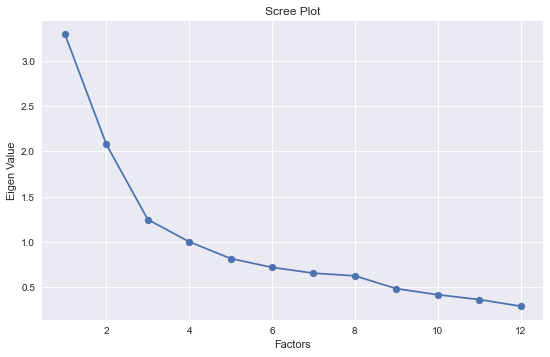

In [72]:
fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=data.shape[1])
fa.fit(data)
ev,_ = fa.get_eigenvalues()

plt.scatter(range(1,data.shape[1]+1),ev)
plt.plot(range(1,data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')

In [75]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(3, rotation="promax")

fa.fit(data)

pd.DataFrame(fa.loadings_,index=data.columns)

,0,1,2
how_concerned_are_you_about_the_spread_of_covid_19_in_your_community,0.58,-0.23,0.07
how_concerned_are_you_that_you_personally_will_contract_covid_19,0.87,0.12,0.06
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19,0.85,0.14,0.07
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy,0.02,-0.18,0.86
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity,0.43,-0.12,-0.06
has_your_income_been_at_all_affected_by_the_covid_19_pandemic,0.14,0.25,0.18
how_difficult_has_it_been_for_you_to_find_groceries_and_other_items,0.16,-0.28,-0.12
have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19,0.00,-0.11,0.80
how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health,0.19,-0.20,-0.19
how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d,0.02,0.80,-0.05


Loadings indicate how much a factor explains a variable. The loading score will range from -1 to 1.Values close to -1 or 1 indicate that the factor has an influence on these variables. Values close to 0 indicates that the factor has a lower influencer on the variable.

## Variance

In [77]:
pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

,0,1,2
Variance,2.09,1.80,1.53
Proportional Var,0.17,0.15,0.13
Cumulative Var,0.17,0.32,0.45


The first row represents the variance explained by each factor. Proportional variance is the variance explained by a factor out of the total variance. Cumulative variance is nothing but the cumulative sum of proportional variances of each factor. In our case, the 3 factors together are able to explain 45% of the total variance.

## Communalities

Communality is the proportion of each variable’s variance that can be explained by the factors. Rotations don’t have any influence over the communality of the variables.

In [78]:
pd.DataFrame(fa.get_communalities(),index=data.columns,columns=['Communalities'])

,Communalities
how_concerned_are_you_about_the_spread_of_covid_19_in_your_community,0.39
how_concerned_are_you_that_you_personally_will_contract_covid_19,0.78
how_concerned_are_you_about_your_access_to_adequate_health_care_services_should_you_contract_covid_19,0.75
how_concerned_are_you_about_the_long_term_negative_impacts_the_coronavirus_could_have_on_your_national_economy,0.77
how_concerned_are_you_that_your_economic_situation_will_be_negatively_impacted_in_the_next_30_days_as_a_result_of_a_change_in_economic_activity,0.20
has_your_income_been_at_all_affected_by_the_covid_19_pandemic,0.12
how_difficult_has_it_been_for_you_to_find_groceries_and_other_items,0.12
have_you_or_a_family_member_been_affected_by_price_gouging_for_goods_and_services_related_to_the_coronavirus_covid_19,0.65
how_much_of_an_impact_do_you_believe_the_covid_19_pandemic_and_subsequent_quarantine_measures_have_had_on_your_mental_and_emotional_health,0.11
how_much_do_you_agree_with_the_following_statement_u201ci_am_well_informed_about_covid_19_and_understand_where_to_get_additional_informationu201d,0.64


## Factor scores

In [79]:
factorScores = fa.transform(data)

In [80]:
factorScoresDF = pd.DataFrame(data = factorScores,
  columns = ['fa1', 'fa2', 'fa3']) # Moving those from an array to a pandas data frame for pd.concat

In [81]:
factorScoresDF

,fa1,fa2,fa3
0,0.43,0.25,0.71
1,0.44,-0.92,-0.68
2,0.08,-0.84,-0.47
3,0.06,-1.16,-0.30
4,0.24,-0.02,-0.03
...,...,...,...
2866980,-1.47,0.95,1.36
2866981,0.03,-0.67,0.49
2866982,0.24,-0.77,-0.31
2866983,1.07,0.60,0.80
